# Priming Dataset
The goal of this notebook is to implement and dataset class based on the SBD for training and PascalVOC2011 for validation. This dataset is to be used for semantic segmentation and be later used for priming the network.

This dataset class follows that of KITTI in the following link:
https://github.com/PyTorchLightning/pytorch-lightning/blob/master/pl_examples/domain_templates/semantic_segmentation.py

In [1]:
import os
import random

from PIL import Image
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

## Define some helper functions and variables for visualization

In [2]:
def make_palette(num_classes):
    """
    Maps classes to colors in the style of PASCAL VOC.
    Close values are mapped to far colors for segmentation visualization.
    See http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit
    Takes:
        num_classes: the number of classes
    Gives:
        palette: the colormap as a k x 3 array of RGB colors
    """
    palette = np.zeros((num_classes, 3), dtype=np.uint8)
    for k in np.arange(0, num_classes):
        label = k
        i = 0
        while label:
            palette[k, 0] |= (((label >> 0) & 1) << (7 - i))
            palette[k, 1] |= (((label >> 1) & 1) << (7 - i))
            palette[k, 2] |= (((label >> 2) & 1) << (7 - i))
            label >>= 3
            i += 1
    return palette

In [3]:
palette = make_palette(256).reshape(-1)

In [4]:
label2category_dict = {0:'background', 1:'aeroplane', 2:'bicycle', 3:'bird', 4: 'boat', 5:'bottle', 6:'bus', 
                       7:'car', 8:'cat', 9:'chair', 10:'cow', 11:'diningtable', 12:'dog', 13:'horse', 14:'motorbike',
                       15:'person', 16:'pottedplant', 17:'sheep', 18:'sofa', 19:'train', 20:'tvmonitor'}

## Define the dataset class

In [5]:
# Define void and valid labels
DEFAULT_VOID_LABELS = [255]
DEFAULT_VALID_LABELS = range(0, 20)#(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)

In [6]:
print(range(0, 20))

range(0, 20)


In [7]:
class SBD(Dataset):
    '''
    Class for SBD Semantic Boundaries Dataset and Benchmark
    Dataset link - http://home.bharathh.info/pubs/codes/SBD/download.html#:~:text=Overview,as%20opposed%20to%20semantic%20segmentations.&text=The%20dataset%20and%20benchmark%20can%20be%20downloaded%20as%20a%20single%20tarball%20here.
    
    The training set in this dataset is based on the PASCAL VOC dataset.
    The test set, with no intersection with training, consists of 736 images according to the following link:
    https://github.com/shelhamer/fcn.berkeleyvision.org/tree/master/data/pascal
    
    There are a total of 20 classes in addition to ``background'' and the ignore label (set to 255).
    
    The training and test data must be in separate directories, each containing two subdirectories called "img" and "SegmentationClass" containing images and masks.
    '''
    
    TRAIN_IMAGE_PATH = os.path.join('train', 'img')
    TRAIN_MASK_PATH = os.path.join('train', 'SegmentationClass')

    def __init__(
        self,
        data_path: str,
        split: str,
        img_size: tuple = (500, 500), #------------ Set subjectively -- Check and modify later
        void_labels: list = DEFAULT_VOID_LABELS,
        valid_labels: list = DEFAULT_VALID_LABELS,
        transform=None
    ):
        self.img_size = img_size
        self.void_labels = void_labels
        self.valid_labels = valid_labels
        self.ignore_index = 255
        self.class_map = dict(zip(self.valid_labels, range(len(self.valid_labels))))
        self.transform = transform

        self.split = split
        self.data_path = data_path
        self.img_path = os.path.join(self.data_path, self.TRAIN_IMAGE_PATH)
        self.mask_path = os.path.join(self.data_path, self.TRAIN_MASK_PATH)
        files_list = self.get_filenames(self.img_path)
        self.img_list = self.append_path_filenames(self.img_path, files_list, '.jpg')#self.get_filenames(self.img_path)
        self.mask_list = self.append_path_filenames(self.mask_path, files_list, '.png')

        #----------------- Do we need this? Doesn't the datamodule take care of this?
        # Split between train and valid set (80/20)
        random_inst = random.Random(12345)  # for repeatability
        n_items = len(self.img_list)
        idxs = random_inst.sample(range(n_items), n_items // 5)
        if self.split == 'train':
            idxs = [idx for idx in range(n_items) if idx not in idxs]
        self.img_list = [self.img_list[i] for i in idxs]
        self.mask_list = [self.mask_list[i] for i in idxs]
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = Image.open(self.img_list[idx])
        img = img.resize(self.img_size)
        img = np.array(img)

        mask = Image.open(self.mask_list[idx]).convert('P')
        mask = mask.resize(self.img_size)
        mask = np.array(mask)
        mask = self.encode_segmap(mask)

        if self.transform:
            img = self.transform(img)

        return img, mask
    
    def encode_segmap(self, mask):
        """
        Sets void classes to 255 so they won't be considered for training
        """
        for voidc in self.void_labels:
            mask[mask == voidc] = self.ignore_index
        for validc in self.valid_labels:
            mask[mask == validc] = self.class_map[validc]
        # remove extra idxs from updated dataset
#         mask[mask > 18] = self.ignore_index
        return mask

    def get_filenames(self, path):
        """
        Returns a list of image filenames inside given `path`
        """
        files_list = list()
        for filename in os.listdir(path):
            files_list.append(filename[:-4]) # exclude the extension
#             files_list.append(os.path.join(path, filename))
        return files_list
    
    def append_path_filenames(self, path, files_list, extension):
        '''
        Returns a list of absolute paths to images. 
        
        PRECONDITION: Images are assumed to be in path. For example, if
        files_list was generated from the "img" folder and `path` points to
        the mask directory, the same filenames for mask files are assumed
        to be in the mask directory. This is to ensure self.img_list and 
        self.mask_list match in ordering of images.
        '''
        
        abs_files_list = list()
        for filename in files_list:
            abs_files_list.append(os.path.join(path, filename + extension))
            
        return abs_files_list

## Visualize some of the images

In [8]:
dataset_path = '/mnt/storage/Work/datasets/priming/SBD_dataset/benchmark_RELEASE/priming_sdb_dataset'
prime_sbd = SBD(dataset_path, 'train')

Labels in this image:  ['background', 'boat']


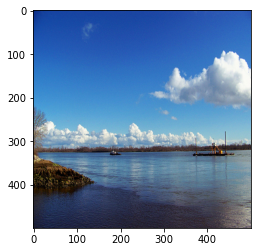

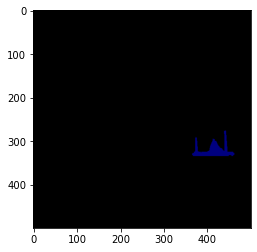

In [12]:
img_indx = 2550
img, mask = prime_sbd.__getitem__(img_indx)

# Plot the original image
plt.figure()
plt.imshow(img)

# Plot the mask according to DEFAULT_VALID_LABELS
# To plot the masks based on the labels, the image palette is required
# The palette was defined above. If the cell was not excuted, run that cell first.
label_im = Image.fromarray(mask)
label_im.putpalette(palette)
plt.figure()
plt.imshow(label_im)

# categories = [category for key in np.tolist(np.unique(mask)) ]
print('Labels in this image: ', [label2category_dict[i] for i in (np.unique(mask)).tolist()])